# TJAAG - Research & Analysis (Project #4)
Holden Bruce

For the TJAAG Research & Data project, I will be focused on modeling the relationship between geography, wealth, and admissions.

#### What I was tasked with:
- Create charts showing average wealth of an MS [I think that means middle school] median income over time
 - How I am going to solve this:
   - Using census data per zipcode/neighborhood/town to estimate the average wealth of a middle schooler. While this is not a perfect representation, it will be good enough to give a general sense of the wealth of the middle school because ostensibly people live in districts (especially when they have money) so that their children can go there. I will be using family income instead of household income.
   - It might also be a good idea to find data on percentage of middle school aged children living in each zipcode who attend their local public middle school vs enrolling in a private middle school?
<br><br>
- TJ admittances by middle school over time (highlight)
 - <i>see below</i>
<br><br>
- Relationship between draw district median income and TJ admittees; for AAP centers make sure to also compare their regular district vs AAP draw area;
time-series chloropleths showing the change in the geographic distribution of wealth and TJ admittees over time
 - <i>challenging</i>


## Part 1
For TJAAG, apparently, I only need to find the median household income for each middle school region. So, I think it will make sense to first identify which zip codes correspond to which middle schools. Then, compare the census data on median household income over time, grouping by these zipcodes. 

#identify which zip codes correspond to which middle schools 

Once I have this data loaded in, I will need to figure out how to approximate the wealth of each middle school where there are multiple middle schools per town...
How will I do this? Zillow had an interesting region tracker that showed housing prices for middle school regions but that data isn't readily available and does not have direct information on the ~income~ of the families, which is what we are really looking for.

#### Zillow 
My first thought was to use the Zillow API since I know that you can search for houses based on school district. My thought was that home prices could be a proxy for wealth. Unfortunately, their API does not let you store data (only display on webpages) and the API documentation indicates that the 'search by school' feature of their webpage is not an accessible endpoint from their API. In other words: we can't do this. 

#### Census
I have data on the family/household income per town in Fairfax County, VA in 2017. I'm interested in looking at the median income of families so that I can estimate the wealth of Middle School families per each middle school in the county. This data is for 2017 and is an average of the past 5 years (I think?) meaning that we don't have year-by-year data to match the admissions statistics for TJ.

I searched through a lot of Census data to try to find what was asked of me but unfortunately, I could not find year-by-year income data; the ACS collects their data in a census fashion every 5 years. I will continue looking for other data sources because it is surprising to me that I couldn't find this data, but for now I am only using data from 2017, which is the only year the Census had on their site for exporting.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [11]:
# What I was able to find was Family Income data collected in 2017 for every town in Fairfax County
# https://data.census.gov/cedsci/table?g=1600000US5179952&tid=ACSDP5Y2016.DP03&hidePreview=true

# here I load in the data
fairfax_towns = pd.read_csv('family_income_fairfax_towns.csv', header=0, index_col=0)
tysons = pd.read_csv('family_income_fairfax_towns_just_tysons.csv', header=0, index_col=0)
fairfax_towns = pd.concat([fairfax_towns,tysons], axis=1)

In [14]:
fairfax_towns.columns #loc[:,'Families']

#indexing this way searches by row, so the [0] is the first row of the
#pandas dataframe, which is 'Families' ... every columns gets returned 
fairfax_towns.iloc[0] 

Fairfax County, Virginia!!Estimate                         33,164
Fairfax County, Virginia!!Margin of Error                    ±717
Fairfax County, Virginia!!Percent                          33,164
Fairfax County, Virginia!!Percent Margin of Error             (X)
Alexandria city, Virginia!!Estimate                         9,678
                                                            ...  
West Springfield CDP, Virginia!!Percent Margin of Error       (X)
Tysons Corner CDP, Virginia!!Estimate                       5,509
Tysons Corner CDP, Virginia!!Margin of Error                 ±411
Tysons Corner CDP, Virginia!!Percent                        5,509
Tysons Corner CDP, Virginia!!Percent Margin of Error          (X)
Name: Families, Length: 92, dtype: object

In [15]:
#adding the second number allows you to index into the specific column 
#(in this case, the column at index 0 = Fairfax County, Virginia!!Estimate)
fairfax_towns.iloc[0][0] 

'33,164'

In [17]:
# Then I looked online to find a list of all the Middle Schools in Fairfax County and 
# where they were located.

# https://en.wikipedia.org/wiki/List_of_Fairfax_County_Public_Schools_middle_schools
towns = {
    0: 'Fairfax County',
    4: 'Alexandria',
    8: 'Annandale',
    12: 'Burke',
    16: 'Centreville',
    20: 'Chantilly',
    24: 'Clifton',
    28: 'Dunn Loring',
    32: 'Fairfax',
    36: 'Falls Church',
    40: 'Fort Hunt',
    44: 'Herndon',
    48: 'Hybla Valley',
    52: 'Lincolnia',
    56: 'Lorton',
    60: 'McLean',
    64: 'Merrifield',
    68: 'Reston',
    72: 'Rose Hill',
    76: 'Springfield',
    80: 'West Springfield',
    84: 'Tysons Corner'
}
# There are 21 towns/sub-regions listed here...Vienna not listed, Tysons Corner added
# Great Falls not listed, Hybla Valley and Lincolnia added
# Used specificity here to designate where middle schools are located

# While this is a good start, it might make sense to add every single region in fairfax
# county and then simply group by locations of elementary schools that feed to the middle
# schools so that i create my own regions to analyze 

# I indexed this way (skipping by 4) to match the setup of the csv file I have, 
# where the information we need for this project is held in every 4th column

## Note: 
Something to consider for later: What would be a good idea for me to do next is to get more specificity around the regions that the Middle Schools are pulling from. In this first pass, I am comparing the median family income of towns to the town in which the middle school is located. But if a middle school pulls from multiple towns, then factoring in the percentage of the school is comprised for students from those towns would be a helpful calculation to track.

### Note:
Liberty Middle School is in Chantilly, which only has 85 families, but the MS 
has over 1100 kids...so clearly they are bringing in students from surrounding
neighborhoods. 

Rocky Run is another example of a school that needs to be given some more thought
since it is on the border of a bunch of different town lines and draws students
from many locations. 

Estimating average wealth for these middle schools is going to be difficult. 

In [18]:
# now save down the relevant information to different variables

# the mean amount a family (households occupied by 2+ people related by birth, marrigae, adoption) is pulling in 
median_family_income = fairfax_towns.iloc[11]

# the average amount a family (households occupied by 2+ people related by birth, marrigae, adoption) is pulling in 
mean_family_income = fairfax_towns.iloc[12]

# the average income earned by each person in a given area
per_capita_income = fairfax_towns.iloc[13] 

### Note: 
Something to consider for later: maybe I could consider families twice the national alverage in income as well as families below the federal poverty line as relevant key statistics?

In [19]:
# Loop through the data and add the relevant information, changing the string to an integer
# so that we can actually process numerical values when considering family income 

num_families_in_town = {}
median_family_income = {}
mean_family_income = {}
per_capita_income = {}

for i in range(0, 85, 4):
    print(towns[i])
    print("# of Families in {}:".format(towns[i]), fairfax_towns.iloc[0][i])
    num_families_in_town[towns[i]] = int(fairfax_towns.iloc[0][i].replace(',',''))
    print("Median Family Income in {}:".format(towns[i]), fairfax_towns.iloc[11][i])
    median_family_income[towns[i]] = int(fairfax_towns.iloc[11][i].replace(',',''))
    print("Mean Family Income in {}:".format(towns[i]), fairfax_towns.iloc[12][i])
    mean_family_income[towns[i]] = int(fairfax_towns.iloc[12][i].replace(',',''))
    print("Per Capita Income in {}:".format(towns[i]), fairfax_towns.iloc[13][i])
    per_capita_income[towns[i]] = int(fairfax_towns.iloc[13][i].replace(',',''))

Fairfax County
# of Families in Fairfax County: 33,164
Median Family Income in Fairfax County: 119,485
Mean Family Income in Fairfax County: 152,903
Per Capita Income in Fairfax County: 57,019
Alexandria
# of Families in Alexandria: 9,678
Median Family Income in Alexandria: 93,099
Mean Family Income in Alexandria: 119,244
Per Capita Income in Alexandria: 36,747
Annandale
# of Families in Annandale: 11,365
Median Family Income in Annandale: 144,937
Mean Family Income in Annandale: 160,248
Per Capita Income in Annandale: 48,996
Burke
# of Families in Burke: 18,254
Median Family Income in Burke: 118,827
Mean Family Income in Burke: 139,963
Per Capita Income in Burke: 43,630
Centreville
# of Families in Centreville: 5,915
Median Family Income in Centreville: 123,554
Mean Family Income in Centreville: 146,835
Per Capita Income in Centreville: 43,856
Chantilly
# of Families in Chantilly: 85
Median Family Income in Chantilly: 176,875
Mean Family Income in Chantilly: 290,967
Per Capita Income 

In [21]:
# Load in TJ admissions data for the Class of 2017

MS_TJ_2017 = pd.read_csv('2017_MS_TJ_admissions.csv', header=0)

# rename the first columns containing all the middle school names
MS_TJ_2017 = MS_TJ_2017.rename(columns={'Unnamed: 0': "School"}) 
MS_TJ_2017.head()

,School,Town,Region,Total Tested,Total Semi-finalists,Total Admitted
0,Carson,Herndon,1,217,147,64
1,Cooper,McLean,1,30,17,5
2,Franklin,Chantilly,5,41,22,2
3,Frost,Fairfax,5,105,61,21
4,Glasgow,Lincolnia,2,66,12,3


In [22]:
# create a new dataframe that only contains the school names and the total number of admitted students
col = ['School', 'Total Admitted']
MS_TJ_2017_admitted = MS_TJ_2017[col]
MS_TJ_2017_admitted.head()

,School,Total Admitted
0,Carson,64
1,Cooper,5
2,Franklin,2
3,Frost,21
4,Glasgow,3


In [23]:
# Sort this list from most acceptances to least:
MS_TJ_2017_admitted_ordered = MS_TJ_2017_admitted.sort_values(by=['Total Admitted'], ascending=False, ignore_index=True)
MS_TJ_2017_admitted_ordered.head()

,School,Total Admitted
0,Carson,64
1,Rocky Run,55
2,Longfellow,55
3,Kilmer,38
4,Lake Braddock,21


###  Note:
It might be interesting to see a graph showing the middle schools with the highest rates of acceptance to TJ alongside a grpah showing the richest towns in the county

# Total Students Admitted to TJ by Middle School

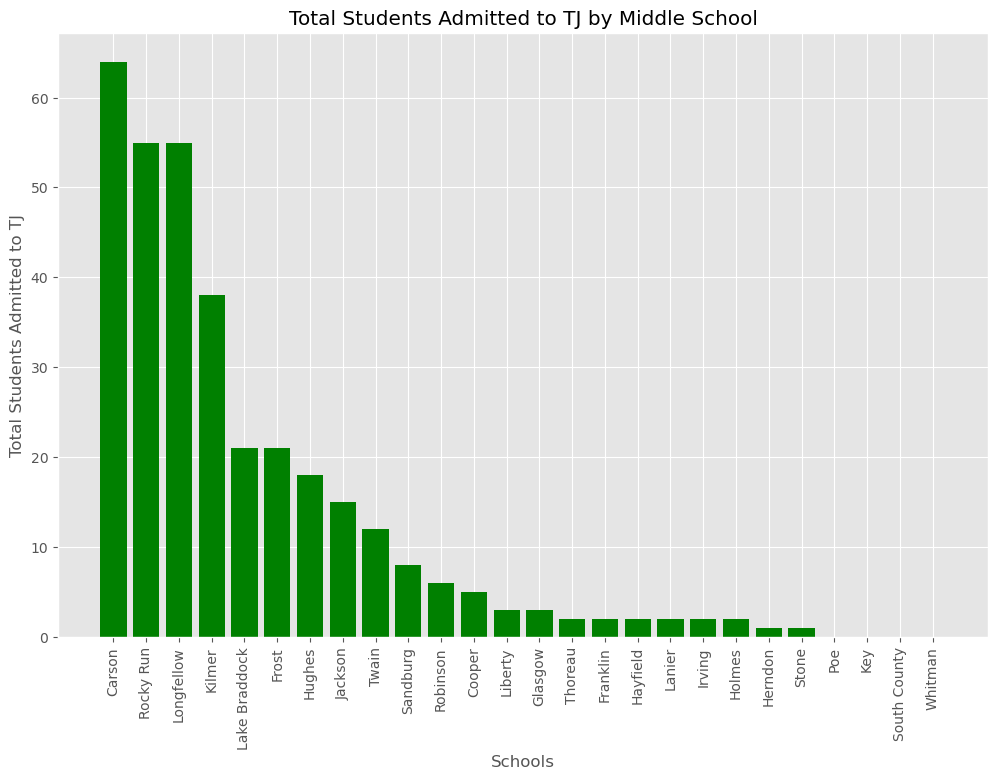

In [29]:
# Total Students Admitted to TJ by Middle School
# https://benalexkeen.com/bar-charts-in-matplotlib/
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

x = MS_TJ_2017_admitted_ordered.loc[:,'School']
y = MS_TJ_2017_admitted_ordered.loc[:,'Total Admitted']

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x, y, color='green')
plt.xlabel('Schools')
plt.ylabel('Total Students Admitted to TJ')
plt.title('Total Students Admitted to TJ by Middle School')
plt.xticks(x_pos,x, rotation='vertical')

plt.show()

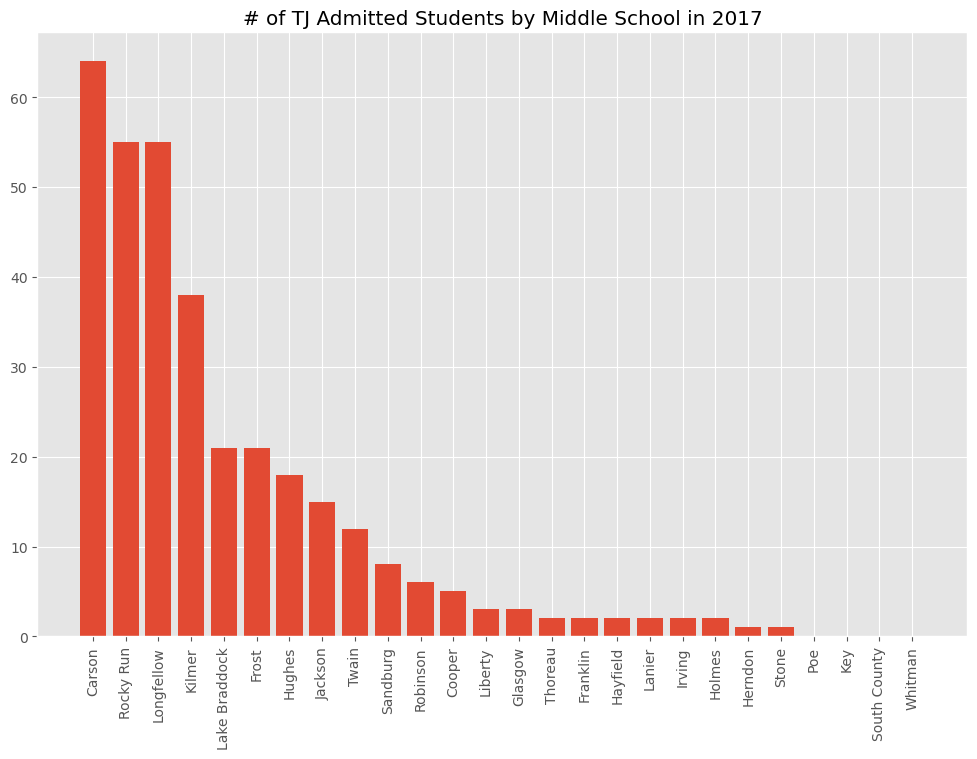

In [31]:
#alternatively
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.bar(range(len(MS_TJ_2017_admitted_ordered)), list(MS_TJ_2017_admitted_ordered['Total Admitted']), align='center')
plt.xticks(range(len(MS_TJ_2017_admitted_ordered)), list(MS_TJ_2017_admitted_ordered['School']), rotation='vertical')
plt.title('# of TJ Admitted Students by Middle School in 2017')
plt.show()

# Median Family Income

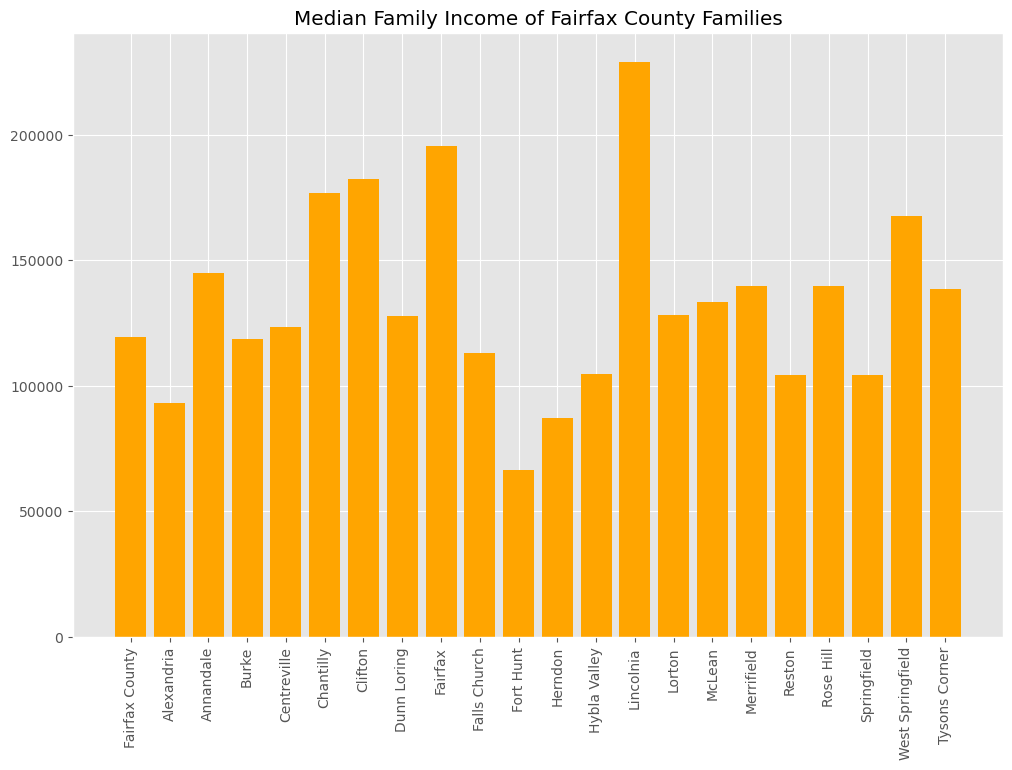

In [35]:
# Median Family Income
# https://stackoverflow.com/questions/16010869/plot-a-bar-using-matplotlib-using-a-dictionary
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.bar(range(len(median_family_income)), list(median_family_income.values()), align='center', color='orange')
plt.xticks(range(len(median_family_income)), list(median_family_income.keys()), rotation='vertical')
plt.title('Median Family Income of Fairfax County Families')
plt.show()

Right, now I need to group the Middle Schools by Town and then plot that against the family income data I have for each of those towns. Maybe the left-y could be the income that corresponds to a bar chart displaying both the Median and Mean (or per capita) income per town, then the right-y could be the number of students accepted from the MS that is represented by that town... this would require me making a new dataframe where I group by town and combine the admissions numbers of middle schools that are in the same town, then I would be able to add the line graph on top of the bar chart so that yo could visualize the income per town on top of the admissions rates for those towns.

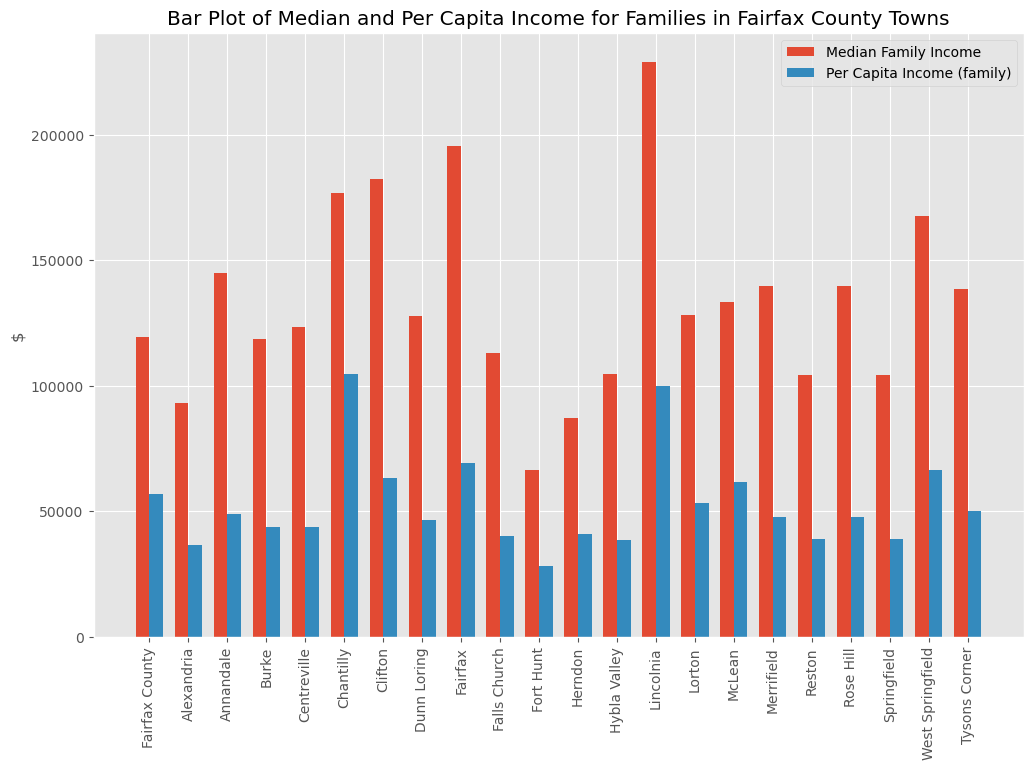

In [40]:
# https://stackoverflow.com/questions/32474434/trying-to-plot-a-line-plot-on-a-bar-plot-using-matplotlib

N = len(median_family_income)
list(median_family_income.values())
list(per_capita_income.values())

ind = np.arange(N)
width = 0.35

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.bar(ind, list(median_family_income.values()), width, label = 'Median Family Income')
plt.bar(ind+width, list(per_capita_income.values()), width, label = 'Per Capita Income (family)')

plt.ylabel('$')
plt.rcParams['figure.figsize']=[10,10]


plt.xticks(ind+width/2, list(median_family_income.keys()), rotation='vertical')
plt.legend(loc = 'best')
plt.title('Bar Plot of Median and Per Capita Income for Families in Fairfax County Towns')
plt.show()

In [50]:
# uncomment this if you want to see a list of the middle schools and their corresponding towns 
#MS_TJ_2017

In [41]:
# Now I need to combine the admissions data, grouping by town 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html
    #Group by: split-apply-combine
MS_TJ_2017
MS_TJ_2017_admitted
MS_TJ_2017_admitted_ordered

#aggregate
grouped_town = MS_TJ_2017.groupby('Town')
grouped_town_and_school = MS_TJ_2017.groupby(['Town','School'])

grouped_town.aggregate(np.sum) #this only looks at towns and sums the values...this is what i want to plot
grouped_town_and_school.aggregate(np.sum) #this does not sum values and just couples the schools with their towns
    #this will be helpful to just see in a chart, not that helpful for plotting

admitted_by_town = grouped_town.aggregate(np.sum).sort_values(by=['Total Admitted'], ascending=False)['Total Admitted']

grouped_towns = list(admitted_by_town.index)

In [42]:
# Median Income
median_dict_grouped_by_town = {key: median_family_income[key] for key in grouped_towns}
median_dict_grouped_by_town

{'Herndon': 87372,
 'McLean': 133273,
 'Chantilly': 176875,
 'Tysons Corner': 138782,
 'Fairfax': 195553,
 'Burke': 118827,
 'Reston': 104200,
 'Merrifield': 139955,
 'Rose Hill': 139955,
 'Fort Hunt': 66512,
 'Lincolnia': 229231,
 'Clifton': 182443,
 'Alexandria': 93099,
 'West Springfield': 167879,
 'Dunn Loring': 127808,
 'Centreville': 123554,
 'Lorton': 128125,
 'Annandale': 144937,
 'Springfield': 104200,
 'Hybla Valley': 104922}

In [43]:
# Per Capita Income
per_capita_dict_grouped_by_town = {key: per_capita_income[key] for key in grouped_towns}
per_capita_dict_grouped_by_town 

{'Herndon': 40961,
 'McLean': 61815,
 'Chantilly': 104645,
 'Tysons Corner': 50311,
 'Fairfax': 69236,
 'Burke': 43630,
 'Reston': 38816,
 'Merrifield': 47669,
 'Rose Hill': 47669,
 'Fort Hunt': 28394,
 'Lincolnia': 100181,
 'Clifton': 63443,
 'Alexandria': 36747,
 'West Springfield': 66593,
 'Dunn Loring': 46489,
 'Centreville': 43856,
 'Lorton': 53527,
 'Annandale': 48996,
 'Springfield': 38816,
 'Hybla Valley': 38777}

<Figure size 720x720 with 0 Axes>

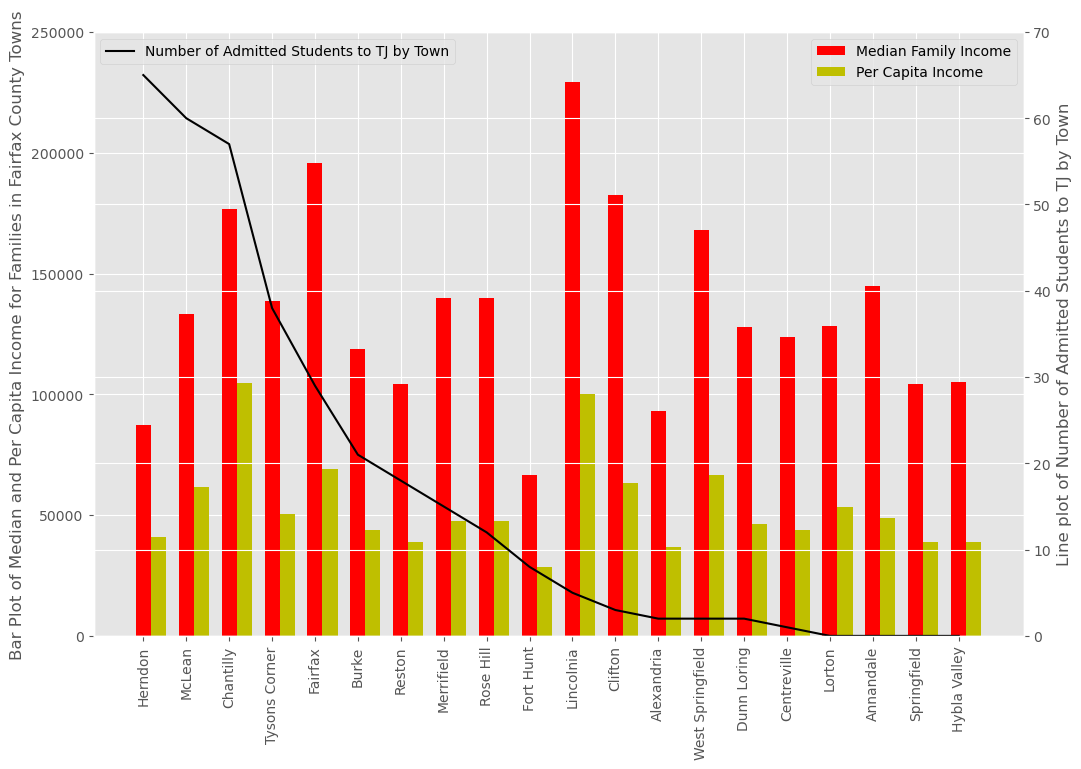

In [44]:
# https://stackoverflow.com/questions/32474434/trying-to-plot-a-line-plot-on-a-bar-plot-using-matplotlib

plt.figure()       
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

grouped_towns = list(admitted_by_town.index)
N = len(grouped_towns)
medians = list(median_dict_grouped_by_town.values())
width = 0.35
per_capitas = list(per_capita_dict_grouped_by_town .values())
ind = np.arange(N)

plt.ylim(0.0, 250000)

plt.bar(ind, medians, width, color='r', label='Median Family Income')
plt.bar(ind+width, per_capitas, width, color='y', label='Per Capita Income')
plt.ylabel('Bar Plot of Median and Per Capita Income for Families in Fairfax County Towns')

x = admitted_by_town.index
y = admitted_by_town
x_pos = [i for i, _ in enumerate(x)]

plt.xticks(ind+width/2, x, rotation='vertical')
plt.legend(loc = 'upper right')

axes2 = plt.twinx()
axes2.plot(x, y, color='k', label='Number of Admitted Students to TJ by Town')
axes2.set_ylim(0.0, 70.0)
axes2.set_ylabel('Line plot of Number of Admitted Students to TJ by Town')

plt.legend(loc = 'upper left')
plt.rcParams['figure.figsize']=[20,10]
plt.show()

# Middle School TJ Admissions Class of 2017 - 2021

In [45]:
# MJ TJ Admissions Class of 2017-2021
MS_TJ_admissions = pd.read_csv('MS_TJ_admissions.csv', header=0)
MS_TJ_admissions.head()
MS_TJ_admissions = MS_TJ_admissions.rename(columns={'Unnamed: 0': "School"}) 
MS_TJ_admissions.head()

,School,Total Admitted 2017,Total Admitted 2018,Total Admitted 2019,Total Admitted 2020,Total Admitted 2021
0,Carson,64,83,88,98,82
1,Cooper,5,2,2,3,1
2,Franklin,2,3,3,1,2
3,Frost,21,23,21,22,20
4,Glasgow,3,2,5,5,1


In [47]:
#plotly - use this 
import plotly.express as px
#load data into the figure
fig = px.line(MS_TJ_admissions, title='TJ Admissions by Middle School for Class of 2017-2021')
# Show plot 
fig.show()